In [2]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [12]:
import torch
import library
import sindy
from neuromancer import psl
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.plot import pltOL
import matplotlib.pyplot as plt
import itertools

torch.manual_seed(0)
# For now, we use CPU till we fix the cuda utilization error
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Plotting Open Loop System

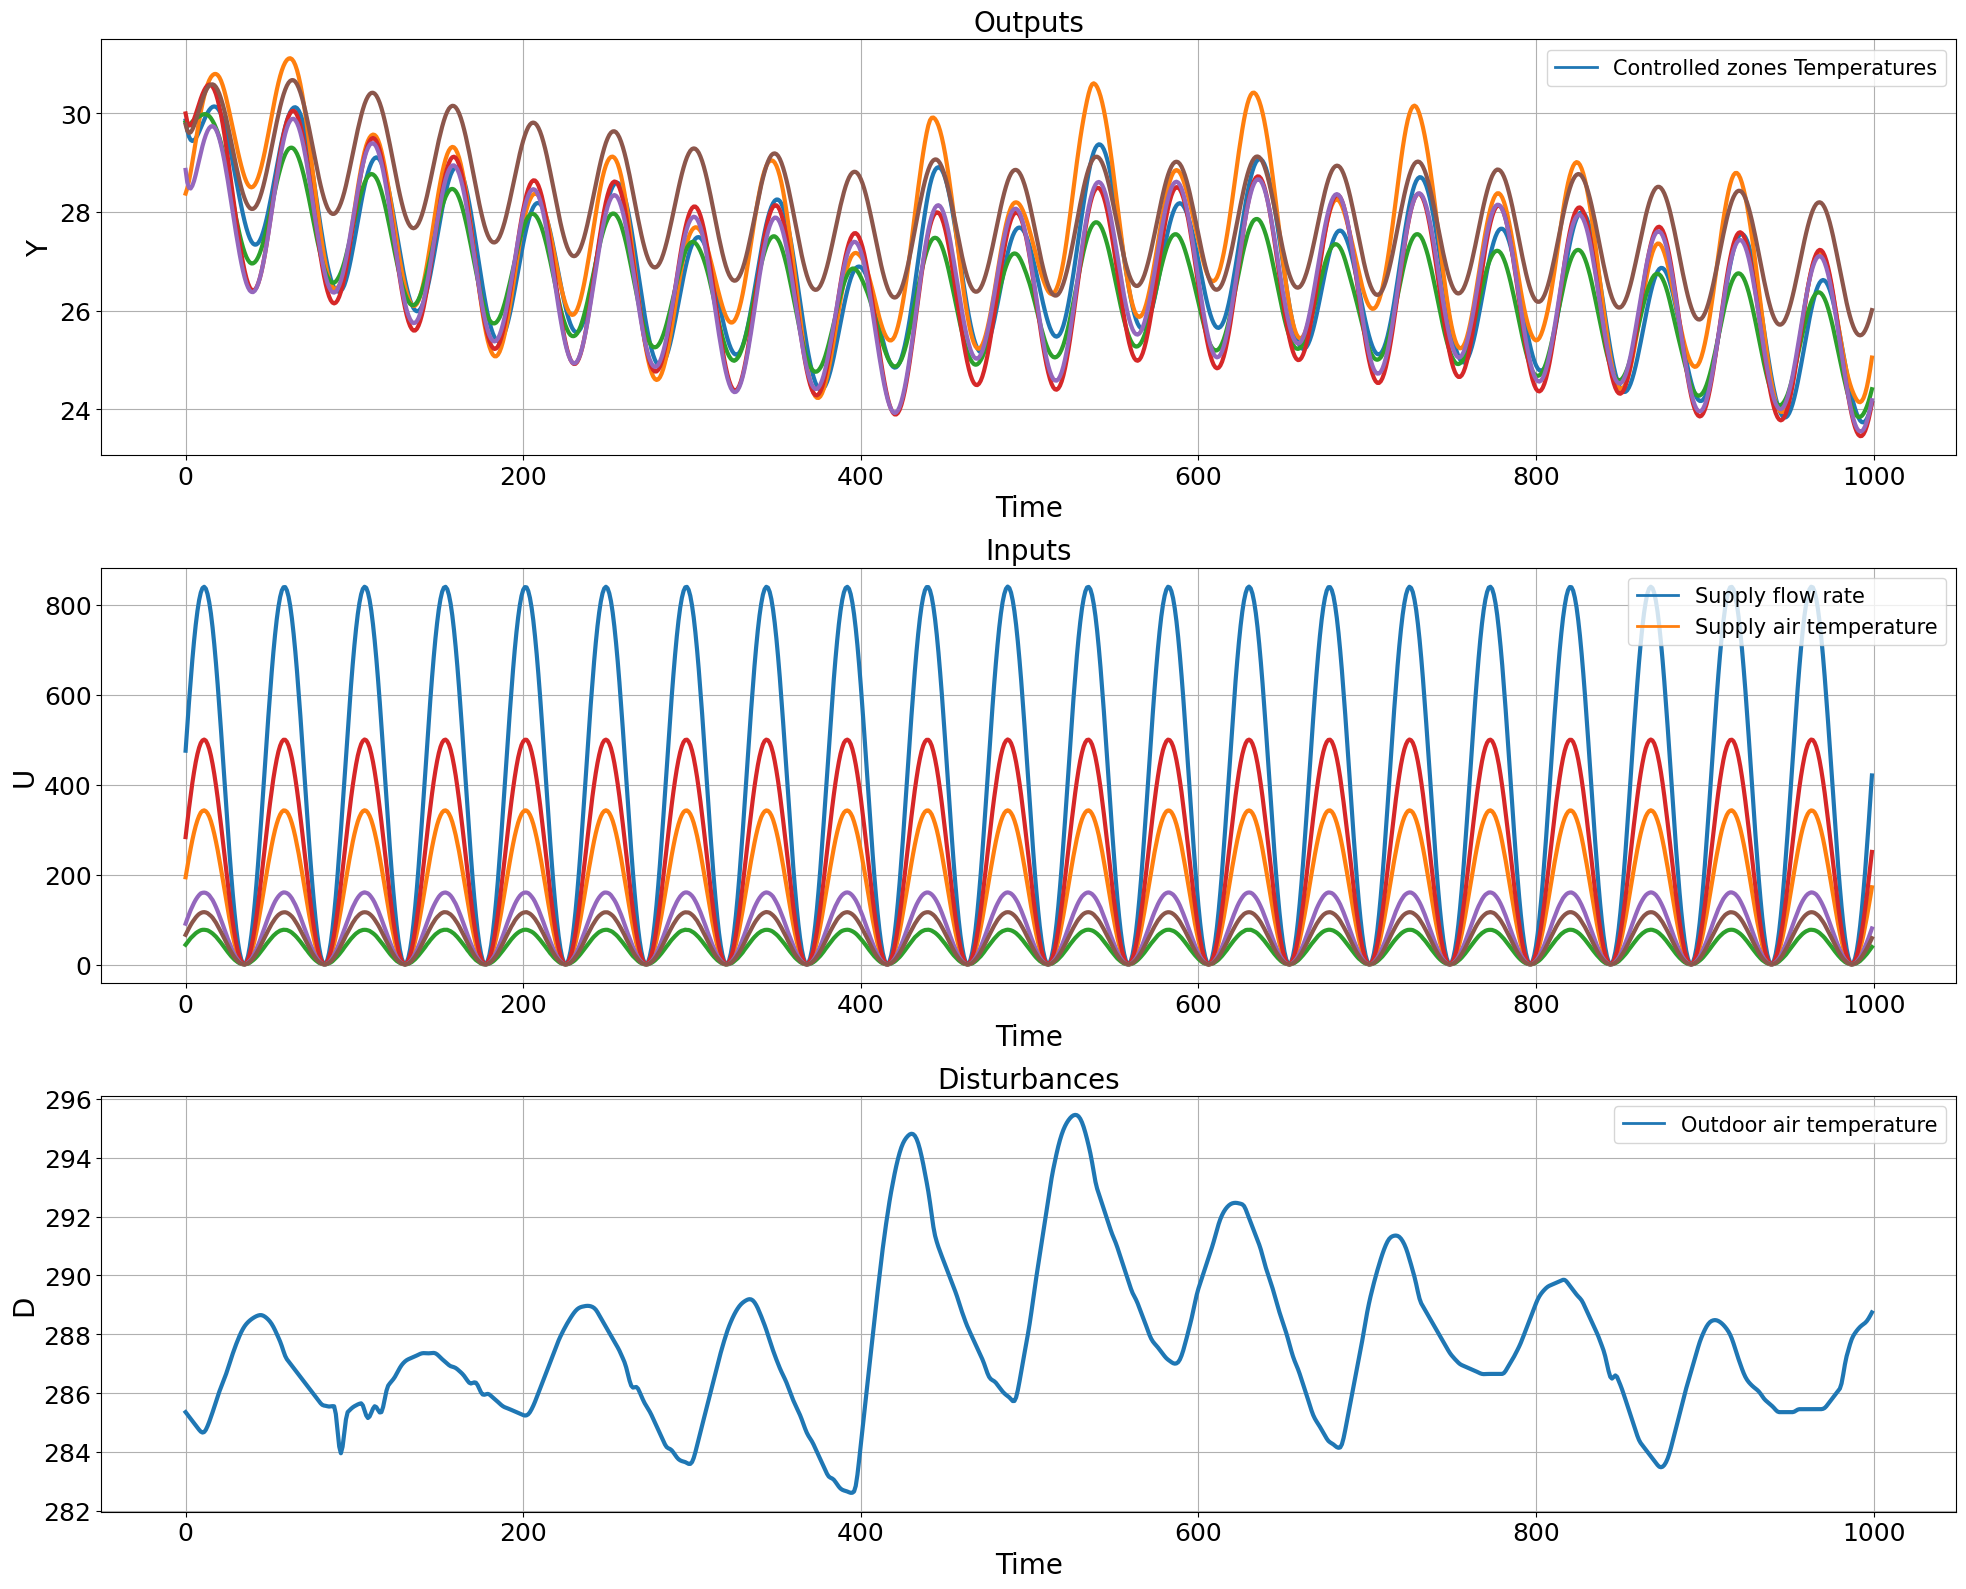

In [6]:
gt_model_name = "LinearReno_ROM40"
gt_model = psl.systems[gt_model_name]()

ts = gt_model.ts
nx = gt_model.nx
ny = gt_model.ny
nu = gt_model.nu
nd = gt_model.nd

raw = gt_model.simulate(nsim=1000)
fig, ax = pltOL(Y=raw['Y'], U=raw['U'], D=raw['D'])
# add custom legends to plots
custom_lines_1 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-')]
custom_lines_2 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
                    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-')]
ax[0, 0].legend(custom_lines_1, ['Controlled zones Temperatures'], fontsize=15, loc="best")
ax[1, 0].legend(custom_lines_2, ['Supply flow rate', 'Supply air temperature'], fontsize=15, loc="best")
ax[2, 0].legend(custom_lines_1, ['Outdoor air temperature'], fontsize=15, loc="best")

### Getting the Training Data

In [7]:
def normalize(x, mean, std):
    return (x - mean) / std

def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nd = sys.nd
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = gt_model.stats['X']['mean']
    std_x = gt_model.stats['X']['std']
    mean_y = gt_model.stats['Y']['mean']
    std_y = gt_model.stats['Y']['std']
    mean_u = gt_model.stats['U']['mean']
    std_u = gt_model.stats['U']['std']
    mean_d = gt_model.stats['D']['mean']
    std_d = gt_model.stats['D']['std']

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainY = normalize(train_sim['Y'][:length], mean_y, std_y)
    trainY = trainY.reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    trainD = normalize(train_sim['D'][:length], mean_d, std_d)
    trainD = trainD.reshape(nbatch, nsteps, nd)
    trainD = torch.tensor(trainD, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'yn': trainY[:, 0:1, :],
                              'Y': trainY,
                              'U': trainU,
                              'D': trainD}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devY = normalize(dev_sim['Y'][:length], mean_y, std_y)
    devY = devY.reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    devD = normalize(dev_sim['D'][:length], mean_d, std_d)
    devD = devD[:length].reshape(nbatch, nsteps, nd)
    devD = torch.tensor(devD, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'yn': devY[:, 0:1, :],
                            'Y': devY,
                            'U': devU,
                            'D': devD}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testY = normalize(test_sim['Y'][:length], mean_y, std_y)
    testY = testY.reshape(1, nbatch*nsteps, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch * nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    testD = normalize(test_sim['D'][:length], mean_d, std_d)
    testD = testD.reshape(1, nbatch*nsteps, nd)
    testD = torch.tensor(testD, dtype=torch.float32)
    test_data = {'X': testX, 'yn': testY[:, 0:1, :],
                 'Y': testY, 'U': testU, 'D': testD,
                 'name': 'test'}

    return train_loader, dev_loader, test_data

In [8]:
def update_nsteps_all(train_loader, dev_loader, new_nsteps, batch_size):
    """
    Updates the time sequence length (nsteps) for train, dev, and test datasets.

    :param train_loader: (DataLoader) Original train DataLoader
    :param dev_loader: (DataLoader) Original dev DataLoader
    :param test_data: (dict) Original test dataset
    :param new_nsteps: (int) New sequence length
    :param batch_size: (int) Batch size for the new DataLoaders

    :return: (DataLoader, DataLoader, dict) Updated train_loader, dev_loader, and test_data
    """

    def reshape_data(tensor, new_nsteps):
        """ Ensures the tensor is sliced properly and reshaped safely """
        total_elements = tensor.shape[0] * tensor.shape[1]  # Compute total available elements
        nbatch = total_elements // new_nsteps  # Compute new number of batches
        length = nbatch * new_nsteps  # Ensure full sequences

        return torch.flatten(tensor, 0, 1)[:length].reshape(nbatch, new_nsteps, tensor.shape[-1])

    def process_loader(loader, name):
        """
        Extracts data from a DataLoader, reshapes it with new_nsteps, and returns a new DataLoader.
        """
        datadict = loader.dataset.datadict

        # Reshape data with new_nsteps
        newX = reshape_data(datadict["X"], new_nsteps)
        newY = reshape_data(datadict["Y"], new_nsteps)
        newU = reshape_data(datadict["U"], new_nsteps)
        newD = reshape_data(datadict["D"], new_nsteps)

        # Create new dataset
        new_data = DictDataset({'X': newX, 'yn': newY[:, 0:1, :], 'Y': newY, 'U': newU, 'D': newD}, name=name)

        # Create new DataLoader
        new_loader = DataLoader(new_data, batch_size=batch_size, collate_fn=new_data.collate_fn, shuffle=True)
        return new_loader

    # Process train and dev loaders
    new_train_loader = process_loader(train_loader, "train")
    new_dev_loader = process_loader(dev_loader, "dev")

    return new_train_loader, new_dev_loader




In [9]:
nsteps_list = [60,10,20,30,40,50,60]

In [10]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = nsteps_list[0] # number of prediction horizon steps in the loss function
bs = 100       # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)



### Function Libraries

In [144]:
# import itertools
# max_degree = 3
# max_freq = 3
#
# theta_1 = library.FourierLibrary(ny, nu+nd, max_freq=max_freq, include_cos=True)
# theta_2 = library.PolynomialLibrary(ny, nu+nd, max_degree=max_degree, interaction=True)
#
# fx = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))
# print(fx)

In [24]:

from library import FunctionLibrary

# Number of features and control variables
n_features = ny
n_controls = nu + nd

# Create an empty list for features and names
theta_funs = []
theta_names = []

# Degree 1 features (x_i)
theta_funs += [(lambda X, u, i=i: X[:, i]) for i in range(n_features)]
theta_names += [f"x_{i}" for i in range(n_features)]

# Sinusoidal features (sin(x_i))
theta_funs += [(lambda X, u, i=i: torch.sin(X[:, i])) for i in range(n_features)]
theta_names += [f"sin(x_{i})" for i in range(n_features)]

# # Product of x_i and sin(x_i)
# theta_funs += [(lambda X, u, i=i: X[:, i] * torch.sin(X[:, i])) for i in range(n_features)]
# theta_names += [f"x_{i} * sin(x_{i})" for i in range(n_features)]

# Quadratic interaction terms (x_i * x_j)
# for i, j in itertools.combinations(range(n_features), 2):
#     theta_funs.append(lambda X, u, i=i, j=j: X[:, i] * X[:, j])
#     theta_names.append(f"x_{i} * x_{j}")


# Control inputs (u_i)
theta_funs += [(lambda X, u, i=i: u[:, i]) for i in range(n_controls)]
theta_names += [f"u_{i}" for i in range(n_controls)]

# # Squared control inputs (u_i^2)
# theta_funs += [(lambda X, u, i=i: u[:, i] ** 2) for i in range(n_controls)]
# theta_names += [f"u_{i}^2" for i in range(n_controls)]

# Interaction terms (x_i * u_j)
theta_funs += [(lambda X, u, i=i, j=j: X[:, i] * u[:, j]) for i in range(n_features) for j in range(n_controls)]
theta_names += [f"x_{i} * u_{j}" for i in range(n_features) for j in range(n_controls)]

# Create function library
theta_library = FunctionLibrary(theta_funs, n_features, n_controls, theta_names)


# Create SINDy model
fx = sindy.SINDy(theta_library)
print(fx)


dx0/dt = 0.053*x_0 + 0.139*x_1 + 0.494*x_2 + 0.149*x_3 + 0.128*x_4 + 0.966*x_5 + 0.179*sin(x_0) + 0.868*sin(x_1) + 0.508*sin(x_2) + 0.953*sin(x_3) + 0.977*sin(x_4) + 0.282*sin(x_5) + 0.658*u_0 + 0.358*u_1 + 0.947*u_2 + 0.456*u_3 + 0.547*u_4 + 0.072*u_5 + 0.268*u_6 + 0.182*x_0 * u_0 + 0.361*x_0 * u_3 + 0.943*x_0 * u_4 + 0.194*x_0 * u_5 + 0.808*x_0 * u_6 + 0.565*x_1 * u_0 + 0.138*x_1 * u_1 + 0.268*x_1 * u_2 + 0.835*x_1 * u_3 + 0.240*x_1 * u_4 + 0.321*x_1 * u_5 + 0.933*x_1 * u_6 + 0.725*x_2 * u_0 + 0.423*x_2 * u_1 + 0.189*x_2 * u_2 + 0.794*x_2 * u_3 + 0.842*x_2 * u_4 + 0.041*x_2 * u_5 + 0.483*x_2 * u_6 + 0.578*x_3 * u_0 + 0.302*x_3 * u_1 + 0.722*x_3 * u_2 + 0.737*x_3 * u_3 + 0.016*x_3 * u_4 + 0.579*x_3 * u_5 + 0.791*x_3 * u_6 + 0.666*x_4 * u_0 + 0.375*x_4 * u_1 + 0.200*x_4 * u_2 + 0.360*x_4 * u_3 + 0.321*x_4 * u_4 + 0.876*x_4 * u_5 + 0.452*x_4 * u_6 + 0.032*x_5 * u_0 + 0.406*x_5 * u_1 + 0.404*x_5 * u_2 + 0.295*x_5 * u_3 + 0.272*x_5 * u_4 + 0.980*x_5 * u_5 + 0.265*x_5 * u_6 
dx1/dt = 0.249

### Creating the Nodes and System

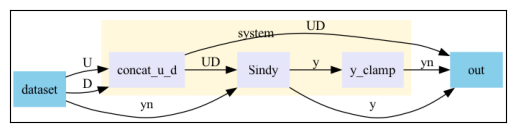

In [25]:
integrator = integrators.Euler(fx, h=ts)
combined_ud = Node(lambda u, d: torch.cat([u, d], dim=-1),
              ['U', 'D'], ['UD'], name="concat_u_d")

integrator_node = Node(integrator, ['yn', 'UD'], ['y'], name="Sindy")
y_bound = Node(lambda x: torch.clamp(x, -20., 20.), ['y'], ['yn'], "y_clamp")
dynamics_model = System([combined_ud, integrator_node, y_bound], name="dynamics_model")
dynamics_model.show()


In [26]:
# %% Constraints + losses:
y = variable("Y")
yhat = variable('yn')[:,:-1,:]

# trajectory tracking loss
reference_loss = 1.*(yhat == y)^2
reference_loss.name = "ref_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

#sparsity
l1 = variable([y], lambda y: torch.norm(list(fx.parameters())[0]))
l2 = variable([y], lambda y: torch.norm(list(fx.parameters())[0], p=2))

l1_weight = [0.01, 0.0001, 0.001, 0.01, 0.1, 0.1]
loss_l1 = l1_weight[0]*(l1 == 0)
loss_l1.name= "l1_loss"

# loss_l2 = l1_weight[0]*(l2 == 0)
# loss_l2.name= "l2_loss"


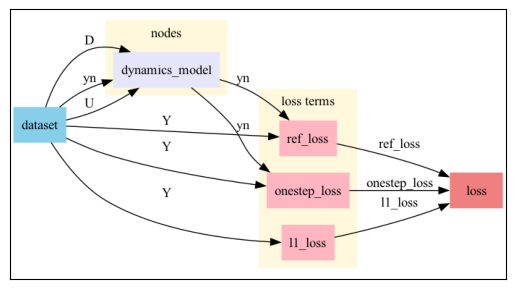

In [27]:

# putting things together
#nodes = [encode_sym, dynamics_model]
objectives = [reference_loss, onestep_loss, loss_l1]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
# plot computational graph
problem.show()

### Training the SINDy Model

In [28]:
optimizer = torch.optim.AdamW(problem.parameters(),
                                lr=.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=300,
    epochs=20000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
    lr_scheduler=True,
    
)


None
Number of parameters: 366


In [29]:
best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0	train_loss: 32.07814	dev_loss: 38.00375	eltime:  0.89879
epoch: 1	train_loss: 30.30892	dev_loss: 36.81687	eltime:  1.01605
epoch: 2	train_loss: 28.74644	dev_loss: 35.71406	eltime:  1.13191
epoch: 3	train_loss: 27.11773	dev_loss: 34.45890	eltime:  1.24348
epoch: 4	train_loss: 25.55402	dev_loss: 33.00270	eltime:  1.35685
epoch: 5	train_loss: 24.02969	dev_loss: 31.65072	eltime:  1.47036
epoch: 6	train_loss: 22.46789	dev_loss: 30.46202	eltime:  1.58181
epoch: 7	train_loss: 20.96192	dev_loss: 29.25881	eltime:  1.69184
epoch: 8	train_loss: 19.49439	dev_loss: 28.22868	eltime:  1.80478
epoch: 9	train_loss: 18.07625	dev_loss: 27.37577	eltime:  1.91664
epoch: 10	train_loss: 16.80593	dev_loss: 26.67367	eltime:  2.02730
epoch: 11	train_loss: 15.50478	dev_loss: 26.09806	eltime:  2.14288
epoch: 12	train_loss: 14.28265	dev_loss: 25.61479	eltime:  2.25381
epoch: 13	train_loss: 13.21746	dev_loss: 25.15825	eltime:  2.36885
epoch: 14	train_loss: 12.22688	dev_loss: 24.78104	eltime:  2.48463
epoch

<All keys matched successfully>

In [89]:
# Curriculum Model training
iterations = len(nsteps_list)
for i in range(1,iterations):
    print(f'training with {nsteps} steps')
    best_model = trainer.train()
    trainer.model.load_state_dict(best_model)
    nsteps = nsteps_list[i]  # increase prediction horizon

    trainer.model.loss.objectives[2].weight, trainer.model.loss.objectives[3].weight = l1_weight[i], l1_weight[i]

    # create dataloaders with batched trajectories using new prediction horizon
    train_loader, dev_loader , test_data = \
        get_data(gt_model, nsim, nsteps, ts, bs)
    trainer.train_data, trainer.dev_data, trainer.test_data = \
        train_loader, dev_loader, test_data
    # reset early stopping
    trainer.badcount = 0

training with 2 steps
epoch: 0	train_loss: 24.18443	dev_loss: 26.50116	eltime:  1.62420
epoch: 1	train_loss: 21.01421	dev_loss: 19.52294	eltime:  1.86128
epoch: 2	train_loss: 16.24678	dev_loss: 10.78475	eltime:  2.03347
epoch: 3	train_loss: 10.54754	dev_loss: 4.54734	eltime:  2.17312
epoch: 4	train_loss: 4.54072	dev_loss: 1.97290	eltime:  2.29591
epoch: 5	train_loss: 2.04121	dev_loss: 1.16352	eltime:  2.40741
epoch: 6	train_loss: 1.31425	dev_loss: 1.22177	eltime:  2.52010
epoch: 7	train_loss: 1.27002	dev_loss: 1.04006	eltime:  2.63218
epoch: 8	train_loss: 0.95353	dev_loss: 0.75469	eltime:  2.74190
epoch: 9	train_loss: 1.22365	dev_loss: 0.72016	eltime:  2.85158
epoch: 10	train_loss: 0.72514	dev_loss: 0.77265	eltime:  2.95920
epoch: 11	train_loss: 1.01334	dev_loss: 0.69311	eltime:  3.07567
epoch: 12	train_loss: 0.99183	dev_loss: 0.70316	eltime:  3.19042
epoch: 13	train_loss: 0.72875	dev_loss: 0.69524	eltime:  3.30697
epoch: 14	train_loss: 0.62448	dev_loss: 0.66441	eltime:  3.42630
epoch:

IndexError: list index out of range

In [30]:
print(fx)

dx0/dt = -0.571*x_0 + -0.895*x_1 + 0.105*x_2 + -0.452*x_3 + -0.381*x_4 + 0.054*x_5 + -0.015*sin(x_0) + 0.346*sin(x_1) + 0.153*sin(x_2) + 0.485*sin(x_3) + 0.463*sin(x_4) + -0.128*sin(x_5) + 0.390*u_0 + 0.383*u_1 + 0.397*u_2 + 0.385*u_3 + 0.386*u_4 + 0.378*u_5 + 1.049*u_6 + -0.044*x_0 * u_0 + -0.124*x_0 * u_1 + -0.121*x_0 * u_2 + 0.036*x_0 * u_3 + 0.296*x_0 * u_4 + -0.040*x_0 * u_5 + 0.180*x_0 * u_6 + 0.086*x_1 * u_0 + -0.152*x_1 * u_1 + -0.079*x_1 * u_2 + 0.236*x_1 * u_3 + -0.093*x_1 * u_4 + -0.051*x_1 * u_5 + 0.748*x_1 * u_6 + 0.047*x_2 * u_0 + -0.105*x_2 * u_1 + -0.224*x_2 * u_2 + 0.082*x_2 * u_3 + 0.107*x_2 * u_4 + -0.299*x_2 * u_5 + -0.733*x_2 * u_6 + -0.148*x_3 * u_1 + 0.082*x_3 * u_2 + 0.090*x_3 * u_3 + -0.303*x_3 * u_4 + -0.054*x_3 * u_6 + 0.043*x_4 * u_0 + -0.117*x_4 * u_1 + -0.213*x_4 * u_2 + -0.125*x_4 * u_3 + -0.145*x_4 * u_4 + 0.157*x_4 * u_5 + -0.372*x_4 * u_6 + -0.281*x_5 * u_0 + -0.055*x_5 * u_1 + -0.056*x_5 * u_2 + -0.122*x_5 * u_3 + -0.135*x_5 * u_4 + 0.292*x_5 * u_5 + 

### Closed Loop System Rollout

In [31]:
# update the rollout length based on the test data
with torch.no_grad():
    #dynamics_model.nsteps = test_data['Y'].shape[1]
    test_output = dynamics_model(test_data)

def denormalize(x, mean, std):
    return (x * std) + mean

pred_traj = denormalize(test_output['yn'][:, :-1, :], gt_model.stats["Y"]["mean"], gt_model.stats["Y"]["std"]).reshape(-1, ny).T
true_traj = denormalize(test_data['Y'], gt_model.stats["Y"]["mean"], gt_model.stats["Y"]["std"]).reshape(-1, ny).T


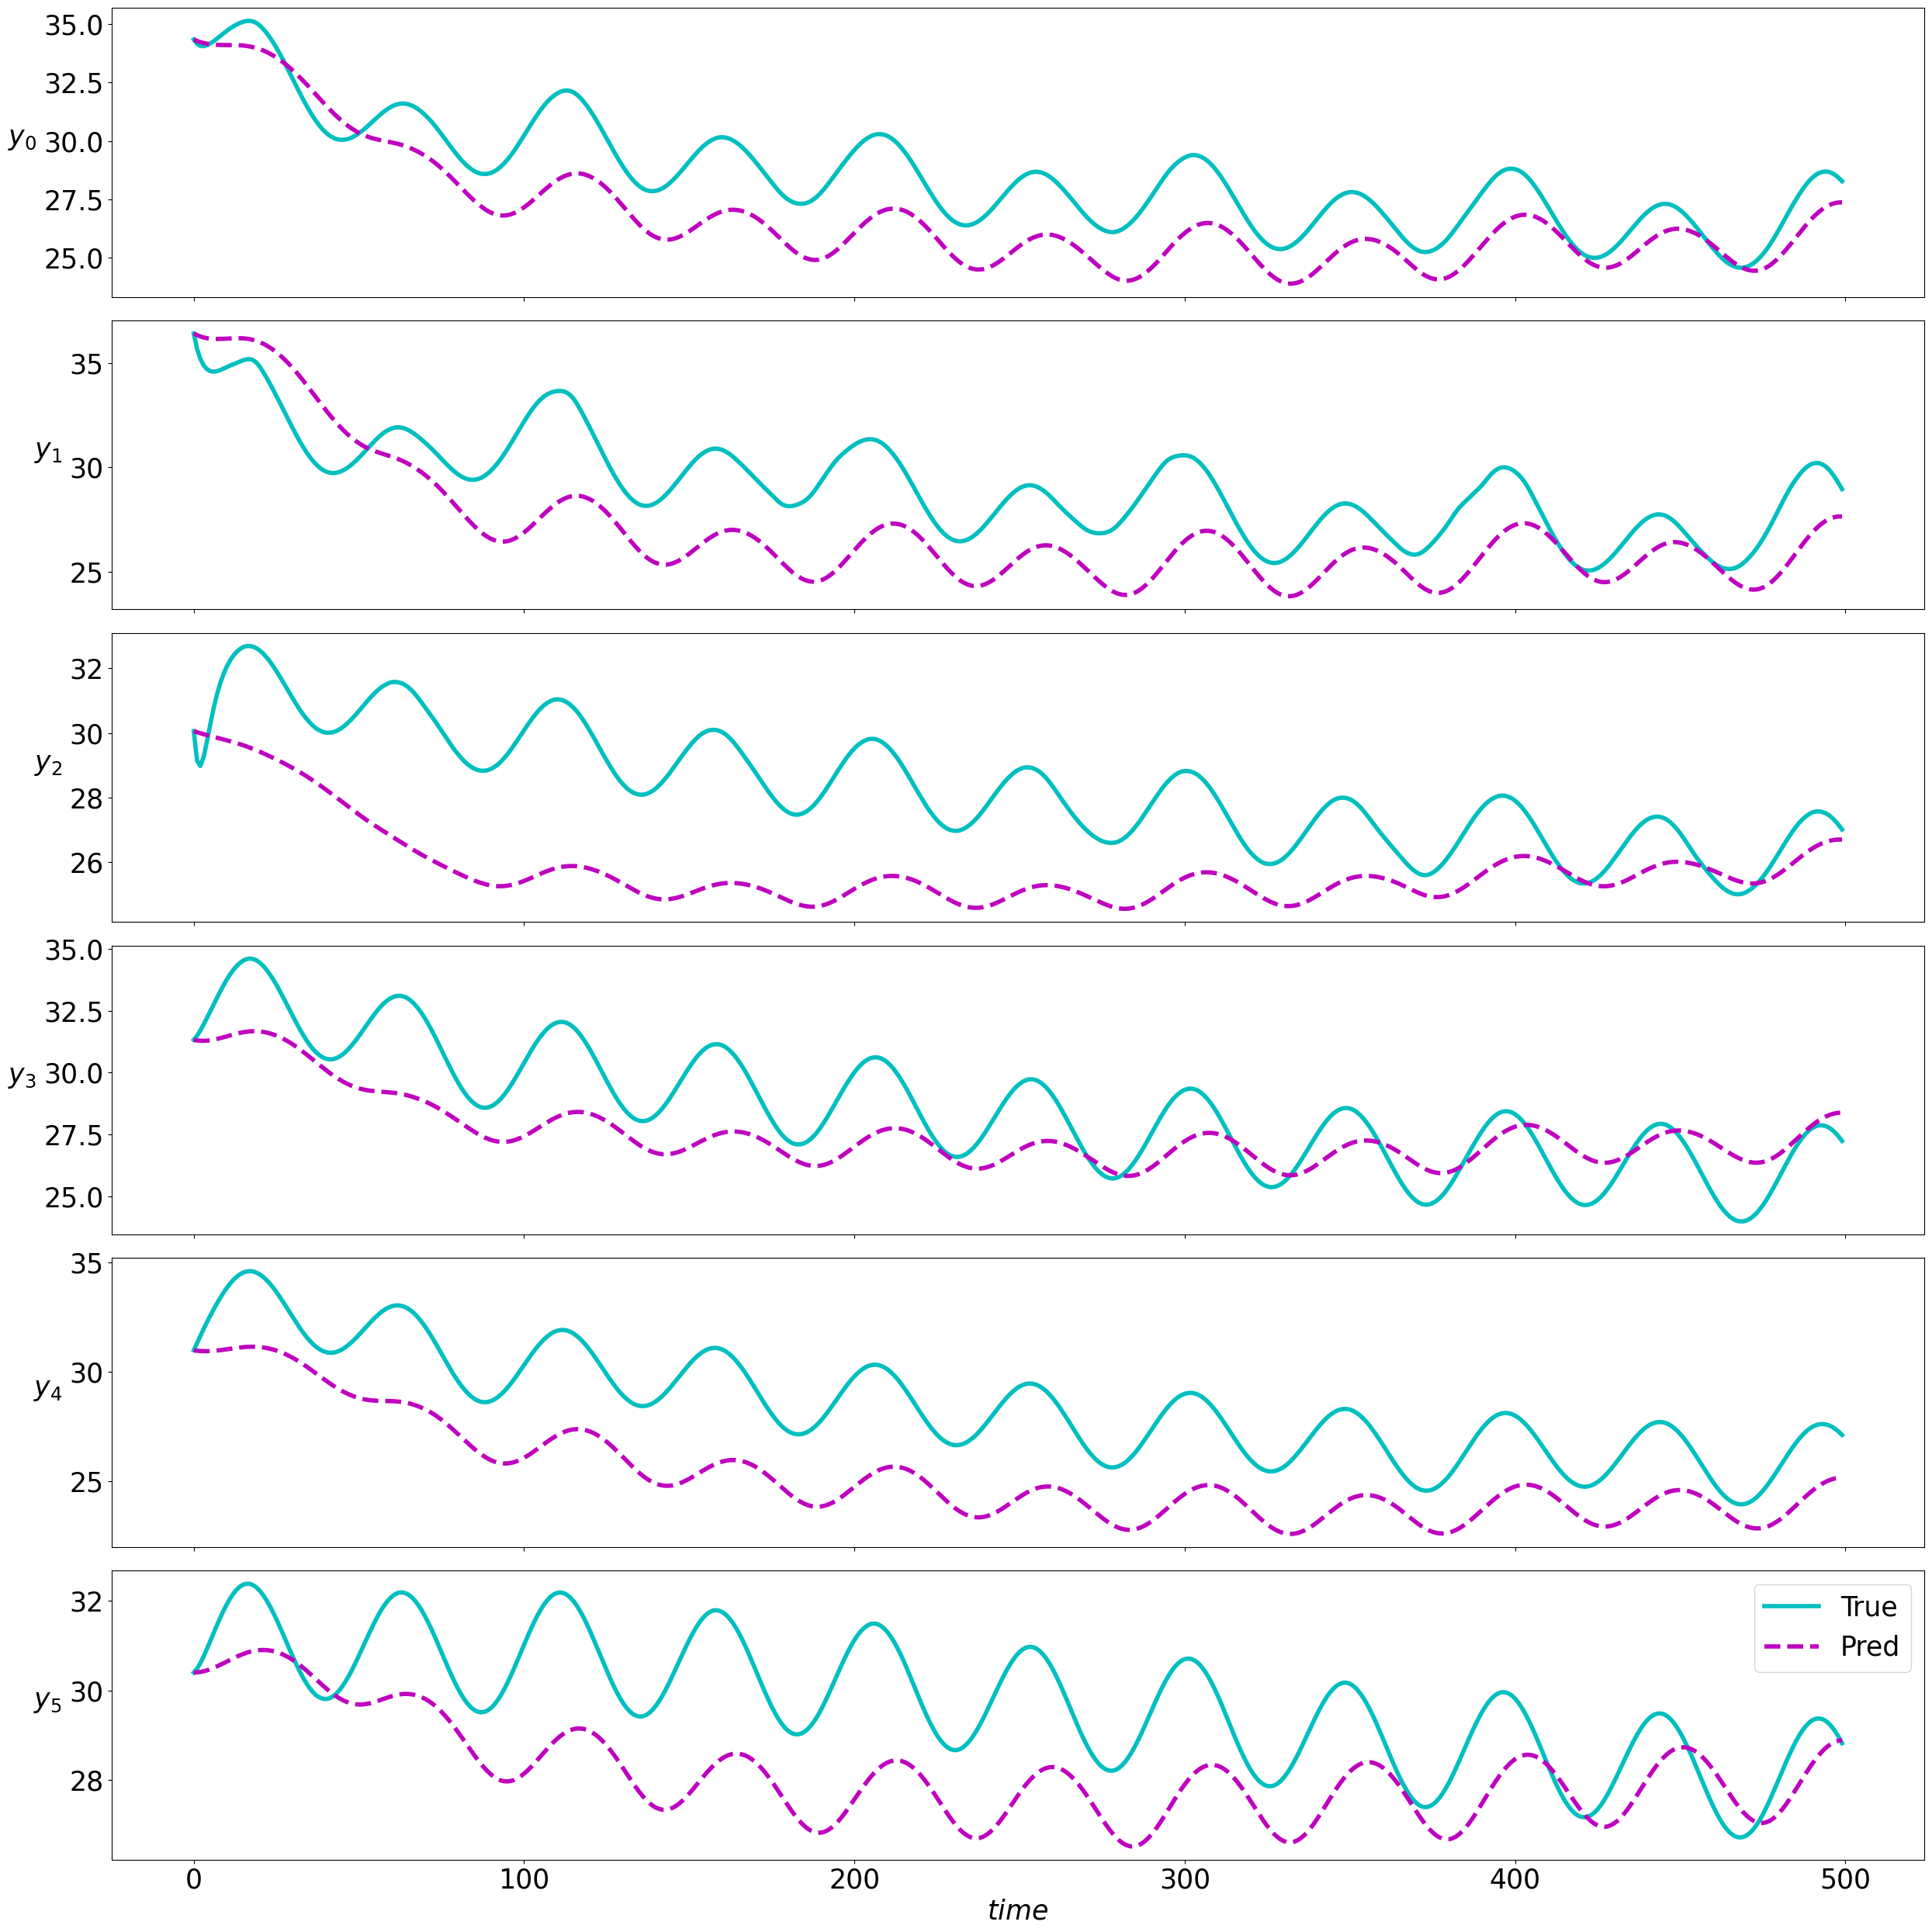

In [32]:

plt_nsteps = 500
figsize = 25
fig, ax = plt.subplots(ny, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if ny > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:plt_nsteps], 'c', linewidth=4.0, label='True')
    axe.plot(t2[:plt_nsteps], 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()